### Links:
* http://www.danvk.org/2015/01/07/finding-blocks-of-text-in-an-image-using-python-opencv-and-numpy.html
* http://felix.abecassis.me/2011/10/opencv-rotation-deskewing/

In [1]:
import sys; sys.path.append('scripts/')

In [2]:
from helpers import *
from curriedCv import *

In [3]:
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 15, 9 

---

# Killing shadow

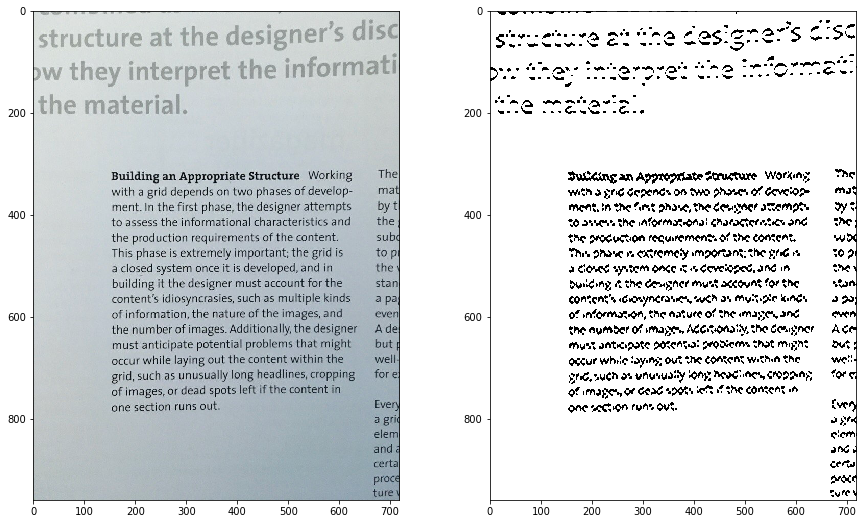

In [4]:
img = load('data/1.jpg')

result = pipe(img, 
              dog, 
              negate, 
              normalize, 
              gaussian, 
              level(black=0.0, white=1, gamma=1), 
              float_to_uint8, 
              to_gray,
              threshold
             )

show(img, result)

# Pixels bars and line height

In [5]:
from scipy.signal import argrelextrema

In [6]:
def pixel_bars(image):
    a = image.copy()
    a[a > 0]= 1
    return np.sum(a, axis=1)

In [7]:
def plot_with_minima():
    plt.figure(figsize=(8,5))
    plt.plot(bars);
    plt.axhline(y=average)
    plt.scatter(minima_i, minima, c='r')

In [8]:
bars = pixel_bars(result)
minima_i = argrelextrema(bars, np.less)[0]
minima  = np.array([bars[i] for i in minima_i])
local_minima = zip(minima_i, minima)
average = (np.max(minima) - np.min(minima)) / 2.0 + np.min(minima)

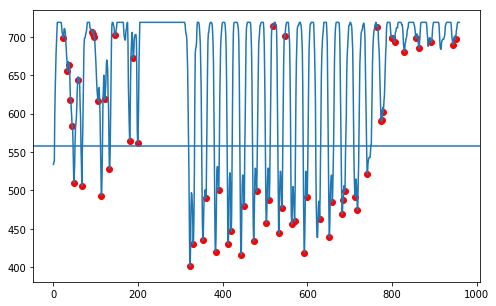

In [9]:
plot_with_minima()

In [10]:
best = [x for x in local_minima if x[1] < average]

In [11]:
distances = [best[i][0]-best[i-1][0] for i in range(1, len(best))]

In [12]:
line_height = np.median(distances)
line_height

20.5

In [13]:
lh = int(line_height) + 1 if np.mean(distances) > line_height else 0

In [14]:
a = to_color(result.copy())

In [15]:
for i in range(int(a.shape[0] // line_height)):
    cv2.line(a, (0, i*lh), (a.shape[1], i*lh), (255,0,0))

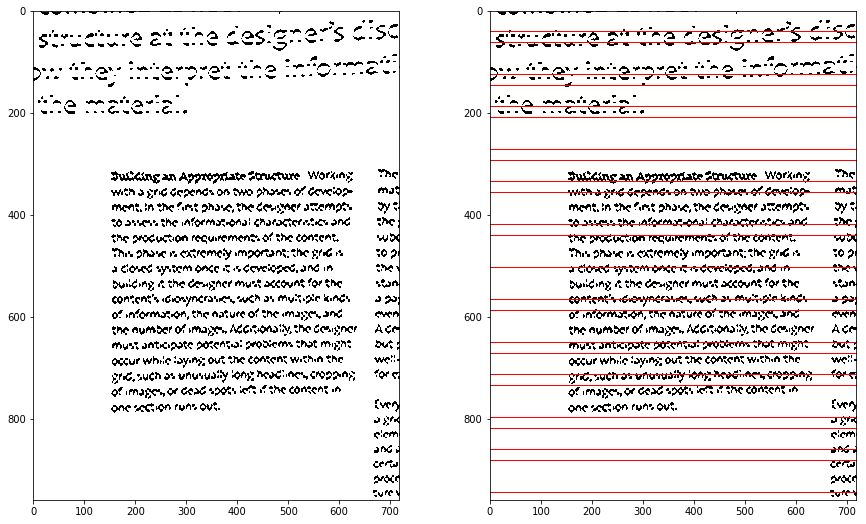

In [16]:
show(result, a)

In [17]:
cv2.imwrite('123.png', a)

True

# Blocks of text and aglomerative clustering

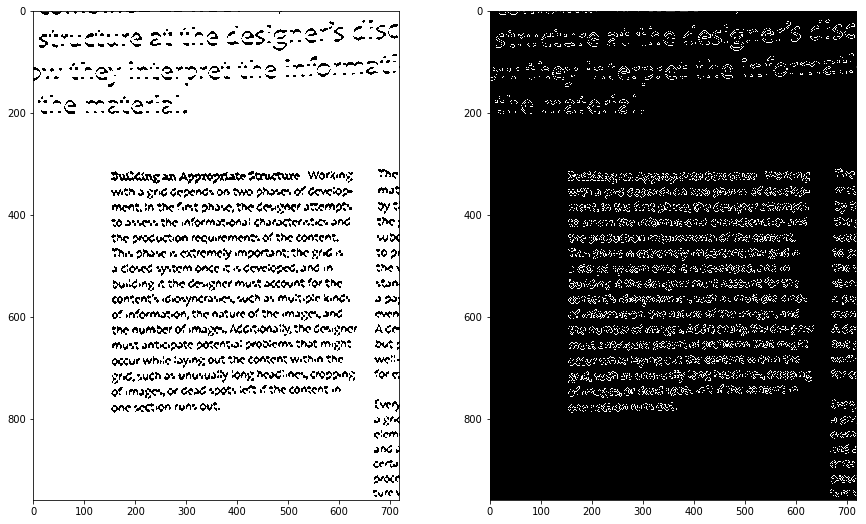

In [18]:
edges = pipe(result, 
             canny
            )

show(result, edges)

In [19]:
count_image, cntrs, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [20]:
len (cntrs)

1701

In [21]:
def draw_countours(gde, cnts, indices):
    a = gde.copy()
    for c in indices:
        a = cv2.drawContours(a, cnts, c, (200,150,0), 3)
    return a

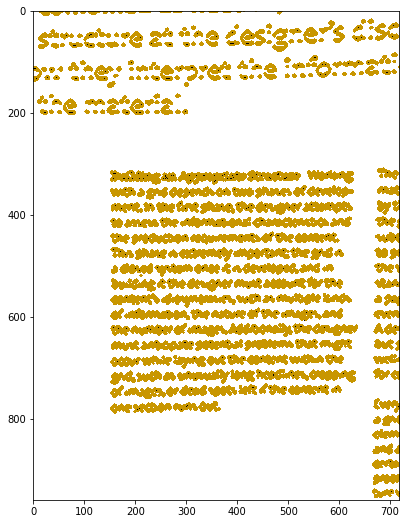

In [22]:
canvas = to_color(result)
show(draw_countours(canvas, cntrs, list(range(len(cntrs)))))

In [23]:
rects = [cv2.boundingRect(x) for x in cntrs]

In [24]:
rects[0]

(669, 950, 5, 5)

In [25]:
def tr_rect(rect):
    hw = rect[-2]/2
    hh = rect[-1]/2
    return (rect[0] + hw, rect[1] + hh)

In [26]:
centers = [tr_rect(x) for x in rects]

In [27]:
df = pd.DataFrame(data=centers, columns=['x', 'y'])

In [29]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
ag = AgglomerativeClustering(compute_full_tree=True, n_clusters=len (cntrs))

In [31]:
ag.fit(df);

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [33]:
ls = linkage(df)

In [34]:
# augmented_dendrogram(ls)

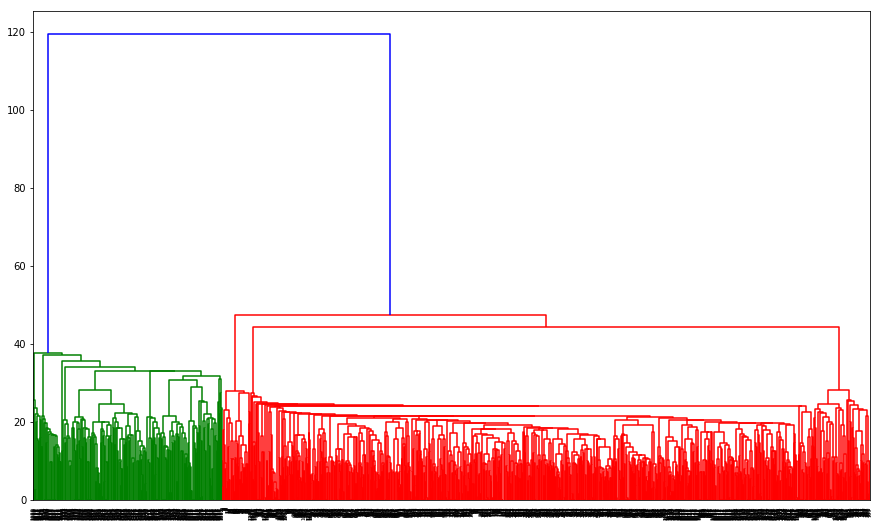

In [37]:
d = dendrogram(ls)

In [38]:
squares = [x[-2]*x[-1] for x in rects]

In [39]:
m = max(squares)
squares.remove(m)

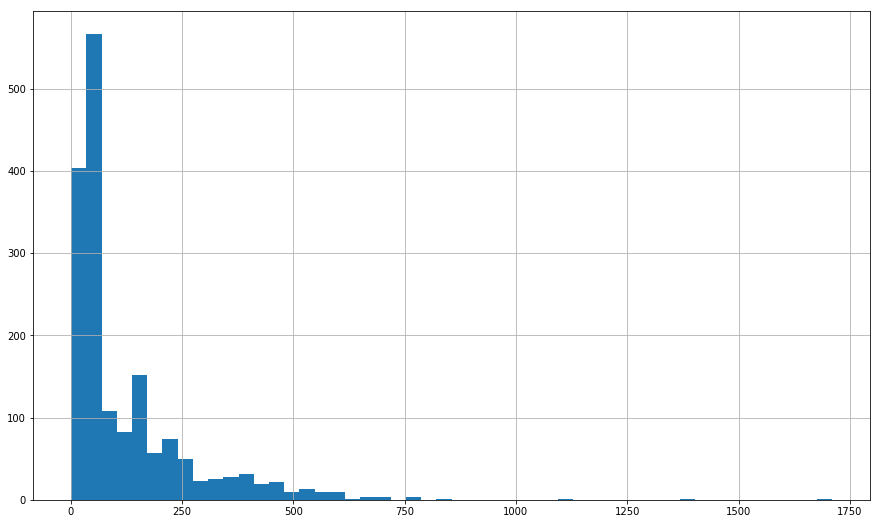

In [40]:
h = pd.Series(squares).hist(bins=50);

In [41]:
h = np.histogram(squares)